In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import pickle

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import tqdm

import autobl.steering
from autobl.steering.configs import *
from autobl.steering.measurement import *
from autobl.steering.acquisition import *
from autobl.steering.optimization import *
from autobl.util import *

torch.set_default_device('cpu')

In [3]:
set_random_seed(123)
plot_graphs = True

In [4]:
data_path = 'data/raw/LiTiO_XANES/dataanalysis/Originplots/Sample1_50C_XANES.csv'

In [5]:
data_all_spectra = pd.read_csv(data_path, header=None)
data_all_spectra

0            1            2            3            4    \
0    4936.000000  4936.500000  4937.000000  4937.500000  4938.000000   
1       0.005420    -0.000265     0.001830     0.003960     0.000507   
2       0.000399     0.001930     0.003800     0.001530     0.001090   
3       0.004960     0.007110     0.001490     0.000174     0.000674   
4       0.003510     0.002480     0.000983     0.000178     0.000705   
..           ...          ...          ...          ...          ...   
124     0.003510     0.002610     0.000659    -0.002530    -0.002550   
125    -0.000972    -0.003700    -0.001510    -0.008560    -0.005030   
126     0.003660     0.001200    -0.000220     0.003630     0.003010   
127     0.000999     0.000135     0.000794    -0.000515     0.000775   
128     0.000594    -0.000550    -0.002230     0.000333     0.001980   

             5            6            7            8           9    ...  \
0    4938.500000  4939.000000  4939.500000  4940.000000  4940.50000  ...   
1       0.002170     0.004290     0.001660     0.008580     0.00457  ...   
2       0.003250     0.000448     0.000324     0.006140     0.00445  ...   
3       0.002970     0.004700     0.001770     0.003300     0.00433  ...   
4       0.002130     0.005450    -0.000759     0.001930     0.00311  ...   
..           ...          ...          ...          ...         ...  ...   
124     0.003750     0.004680    -0.004530     0.000895     0.00416  ...   
125    -0.000713    -0.000946    -0.004490     0.001080    -0.00203  ...   
126     0.003860     0.000327    -0.000153     0.006030     0.00173  ...   
127     0.002160    -0.000492    -0.000762    -0.000787    -0.00152  ...   
128    -0.002470    -0.002660     0.000371     0.007010     0.00361  ...   

            131         132         133         134         135         136  \
0    5001.50000  5002.00000  5002.50000  5003.00000  5003.50000  5004.00000   
1       1.34627     1.33542     1.32561     1.30748     1.27745     1.25692   
2       1.33703     1.32843     1.31673     1.30007     1.27325     1.24884   
3       1.33959     1.32791     1.31768     1.29564     1.27382     1.25032   
4       1.33333     1.32914     1.31438     1.29633     1.27064     1.24557   
..          ...         ...         ...         ...         ...         ...   
124     1.22189     1.24877     1.25049     1.24624     1.23297     1.21781   
125     1.22255     1.22380     1.23450     1.23352     1.22399     1.20301   
126     1.22356     1.23407     1.24095     1.23811     1.22552     1.21022   
127     1.21150     1.21795     1.22707     1.22468     1.21487     1.20169   
128     1.21865     1.23148     1.23490     1.22892     1.21968     1.20823   

            137         138         139         140  
0    5004.50000  5005.00000  5005.50000  5006.00000  
1       1.22866     1.19840     1.16776     1.13832  
2       1.21725     1.19444     1.16368     1.13456  
3       1.22341     1.19401     1.16089     1.13613  
4       1.22360     1.19474     1.16229     1.13286  
..          ...         ...         ...         ...  
124     1.20075     1.18945     1.17262     1.15319  
125     1.19104     1.17716     1.16057     1.14369  
126     1.19423     1.18404     1.16565     1.14718  
127     1.18085     1.16794     1.15274     1.13740  
128     1.19212     1.17831     1.16084     1.15027  

[129 rows x 141 columns]

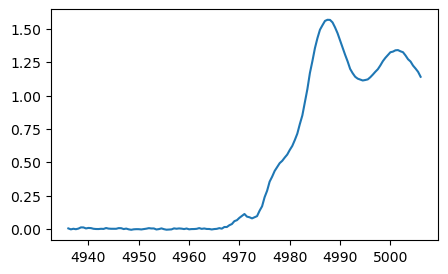

In [6]:
data = data_all_spectra.iloc[len(data_all_spectra) // 2].to_numpy()
energies = data_all_spectra.iloc[0].to_numpy()
energies = torch.tensor(energies)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), data)
plt.show()

Utility functions for analysis

In [7]:
def rms(actual, true):
    return np.sqrt(np.mean((actual - true) ** 2))

def create_intermediate_figure(n_target_measurements, n_plot_interval=20):
    n_plots = int(np.ceil(n_target_measurements / n_plot_interval))
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)
    return fig, ax

def update_intermediate_figure(guide, energies, data, n_measured, i_plot, axes):
    n_rows = len(axes)
    n_cols = len(axes[0])
    # guide.plot_posterior(energies)
    guide.plot_posterior(energies, ax=axes[i_plot // n_cols][i_plot % n_cols])
    axes[i_plot // n_cols][i_plot % n_cols].plot(to_numpy(energies), data, label='Truth', color='gray', alpha=0.6)
    axes[i_plot // n_cols][i_plot % n_cols].set_title('{} points'.format(n_measured))
    axes[i_plot // n_cols][i_plot % n_cols].legend()

def create_intermediate_data_dict(energies, data):
    intermediate_data_dict = {
        'energies': to_numpy(energies),
        'data': to_numpy(data),
        'n_measured_list': [],
        'mu_list': [],
        'sigma_list': []
    }
    return intermediate_data_dict

def update_intermediate_data_dict(guide, config, n_measured, intermediate_data_dict):
    mu, sigma = guide.get_posterior_mean_and_std(energies[:, None])
    mu = mu.squeeze()
    sigma = sigma.squeeze()
    intermediate_data_dict['n_measured_list'].append(n_measured)
    intermediate_data_dict['mu_list'].append(to_numpy(mu))
    intermediate_data_dict['sigma_list'].append(to_numpy(sigma))
    return intermediate_data_dict

def save_intermediate_data_dict(intermediate_data_dict, config, guide, save_dir):
    fname = get_save_name_prefix(config, guide)
    fname = fname + '_intermediate_data.pkl'
    fname = os.path.join(save_dir, fname)
    pickle.dump(intermediate_data_dict, open(fname, 'wb'))

def create_convergence_figure_and_data():
    fig, ax = plt.subplots(1, 1)
    return fig, ax, [], []

def update_convergence_data(guide, n_measured, n_measured_list, metric_list):
    mu, _ = guide.get_posterior_mean_and_std(energies[:, None])
    mu = mu.squeeze()
    metric = rms(mu.detach().cpu().numpy(), data)
    n_measured_list.append(n_measured)
    metric_list.append(metric)
    return n_measured_list, metric_list

def plot_convergence(fig, ax, n_measured_list, metric_list):
    ax.plot(n_measured_list, metric_list)
    ax.set_xlabel('Points measured')
    ax.set_ylabel('RMS')

def get_save_name_prefix(config, guide):
    data_name = os.path.splitext(os.path.basename(data_path))[0]
    
    acquisition_info = config.acquisition_function_class.__name__
    if config.acquisition_function_class in [GradientAwarePosteriorStandardDeviation, FittingResiduePosteriorStandardDeviation]:
        acquisition_info += '_phi_{}'.format(guide.acquisition_function.phi)
    if config.acquisition_function_class == ComprehensiveAugmentedAcquisitionFunction:
        acquisition_info += '_gradOrder_{}_phiG_{}_phiR_{}'.format(guide.acquisition_function.gradient_order, guide.acquisition_function.phi_g, guide.acquisition_function.phi_r)
        if guide.acquisition_function.gradient_order == 2:
            acquisition_info += '_phiG2_{}'.format(guide.acquisition_function.phi_g2)
        
    kernel_info = '{}_lengthscale_{:.3f}'.format(guide.model.covar_module.__class__.__name__, 
                                                 guide.unscale_by_normalizer_bounds(
                                                     guide.model.covar_module.lengthscale.item()
                                                 ))
    if isinstance(guide.model.covar_module, gpytorch.kernels.MaternKernel):
        kernel_info += '_nu_{}'.format(guide.model.covar_module.nu)

    optimizer_info = config.optimizer_class.__name__

    save_name_prefix = '_'.join([data_name, acquisition_info, kernel_info, optimizer_info])
    return save_name_prefix

Creating a common config template:

In [8]:
config = XANESExperimentGuideConfig(
        dim_measurement_space=1,
        num_candidates=1,
        model_class=botorch.models.SingleTaskGP,
        model_params={'covar_module': gpytorch.kernels.MaternKernel(2.5)},
        override_kernel_lengthscale=7,
        noise_variance=1e-6,
        lower_bounds=torch.tensor([energies[0]]),
        upper_bounds=torch.tensor([energies[-1]]),
        n_updates_create_acqf_weight_func=5,
        acqf_weight_func_floor_value=0.1,
        acqf_weight_func_post_edge_gain=3.0,
    
        # optimizer_class=ContinuousOptimizer,
        # optimizer_params={'num_restarts': 2,}
        #                   #'options': {'maxiter': 2}}
    
        # optimizer_class=DiscreteOptimizer,
        # optimizer_params={'optim_func': botorch.optim.optimize.optimize_acqf_discrete, 
        #                   'optim_func_params': {
        #                       'choices': torch.linspace(0, 1, len(energies))[:, None]
        #                   }
        #                  }
    
        optimizer_class=TorchOptimizer,
        optimizer_params={'torch_optimizer': torch.optim.Adam, 'torch_optimizer_options': {'maxiter': 20}}
)

In [9]:
instrument = SimulatedMeasurement(data=(energies[None, :], data))

Sample 10 points with equal spacing to initialize.

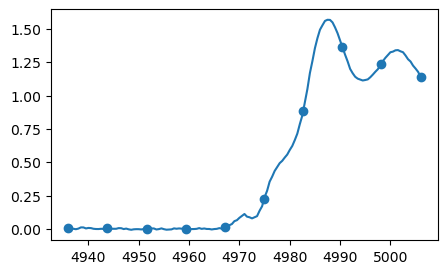

In [10]:
n_init = 10
x_init = torch.linspace(energies[0], energies[-1], n_init).double().reshape(-1, 1)
y_init = instrument.measure(x_init).reshape(-1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), to_numpy(data))
ax.scatter(to_numpy(x_init), to_numpy(y_init))
plt.show()

In [11]:
def run_simulated_experiment(config, x_init, y_init, n_target_measurements=None):
    guide = autobl.steering.guide.XANESExperimentGuide(config)
    guide.build(x_init, y_init)

    if n_target_measurements is None:
        n_target_measurements = len(data) - n_init
    n_plot_interval = 5
    n_measured = n_init

    if plot_graphs:
        fig_intermediate, axes_intermediate = create_intermediate_figure(n_target_measurements, n_plot_interval)
        fig_conv, axes_conv, n_measured_list, metric_list = create_convergence_figure_and_data()
        intermediate_data_dict = create_intermediate_data_dict(energies, data)
        i_plot = 0
    for i in tqdm.trange(n_target_measurements):
        candidates = guide.suggest().double()
        y_new = instrument.measure(candidates).unsqueeze(-1)
        guide.update(candidates, y_new)
        n_measured += len(candidates)
        if plot_graphs:
            intermediate_data_dict = update_intermediate_data_dict(guide, config, n_measured, intermediate_data_dict)
            if i % n_plot_interval == 0:
                update_intermediate_figure(guide, energies, data, n_measured, i_plot, axes_intermediate)
                i_plot += 1
            update_convergence_data(guide, n_measured, n_measured_list, metric_list)

    if plot_graphs:
        plot_convergence(fig_conv, axes_conv, n_measured_list, metric_list)
        fig_intermediate.savefig(os.path.join('outputs', get_save_name_prefix(config, guide) + '_intermediate.pdf'), bbox_inches='tight')
        fig_conv.savefig(os.path.join('outputs', get_save_name_prefix(config, guide) + '_conv.pdf'))
        np.savetxt(os.path.join('outputs', get_save_name_prefix(config, guide) + '_conv.txt'), np.stack([n_measured_list, metric_list]))
        save_intermediate_data_dict(intermediate_data_dict, config, guide, 'outputs')

# Experiments with different acquisition functions

## Posterior standard deviation

In [ ]:
config.acquisition_function_class = PosteriorStandardDeviation
config.acquisition_function_params = {}

In [ ]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=70)

## Gradient-aware posterior standard deviation

In [ ]:
config.acquisition_function_class = GradientAwarePosteriorStandardDeviation
config.acquisition_function_params = {'phi': 1e-2, 'method': 'numerical', 'order': 2}

In [ ]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=70)

## Acquisition function with reference spectra

Given the spectra expected at the beginning and end of a dynamic experiment, a spectrum measured at some point in between can be approximated by a linear combination between the beginning and end spectra. 

We design an acquisition function where the current posterior mean is linearly fit with the beginning and end spectra as bases, and the fitting residue is calculated and returned as the acquisition function value. 

In [12]:
ref_spectra_0 = torch.tensor(data_all_spectra.iloc[1].to_numpy())
ref_spectra_1 = torch.tensor(data_all_spectra.iloc[-1].to_numpy())
ref_spectra_y = torch.stack([ref_spectra_0, ref_spectra_1], dim=0)
ref_spectra_x = energies

# config.acquisition_function_class = FittingResiduePosteriorStandardDeviation
# config.acquisition_function_params = {'reference_spectra_x': ref_spectra_x, 
#                                       'reference_spectra_y': ref_spectra_y, 
#                                       'phi': 100}
config.acquisition_function_class = ComprehensiveAugmentedAcquisitionFunction
config.acquisition_function_params = {'gradient_order': 2,
                                      'differentiation_method': 'numerical',
                                      'reference_spectra_x': ref_spectra_x, 
                                      'reference_spectra_y': ref_spectra_y, 
                                      'phi_r': 1e3,
                                      'phi_g': 1e-2,
                                      'phi_g2': 1e-4,
                                      'addon_term_lower_bound': 1e-2,
                                      'debug': True}

[2024-04-17 16:11:23,632] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-17 16:11:23,703] Kernel lengthscale after optimization (normalized & standardized): [[0.29607319]]
[2024-04-17 16:11:23,705] Kernel lengthscale overriden to: 7 (0.09999999999999999 after normalization)
  0%|                                                                                   | 0/70 [00:00<?, ?it/s]

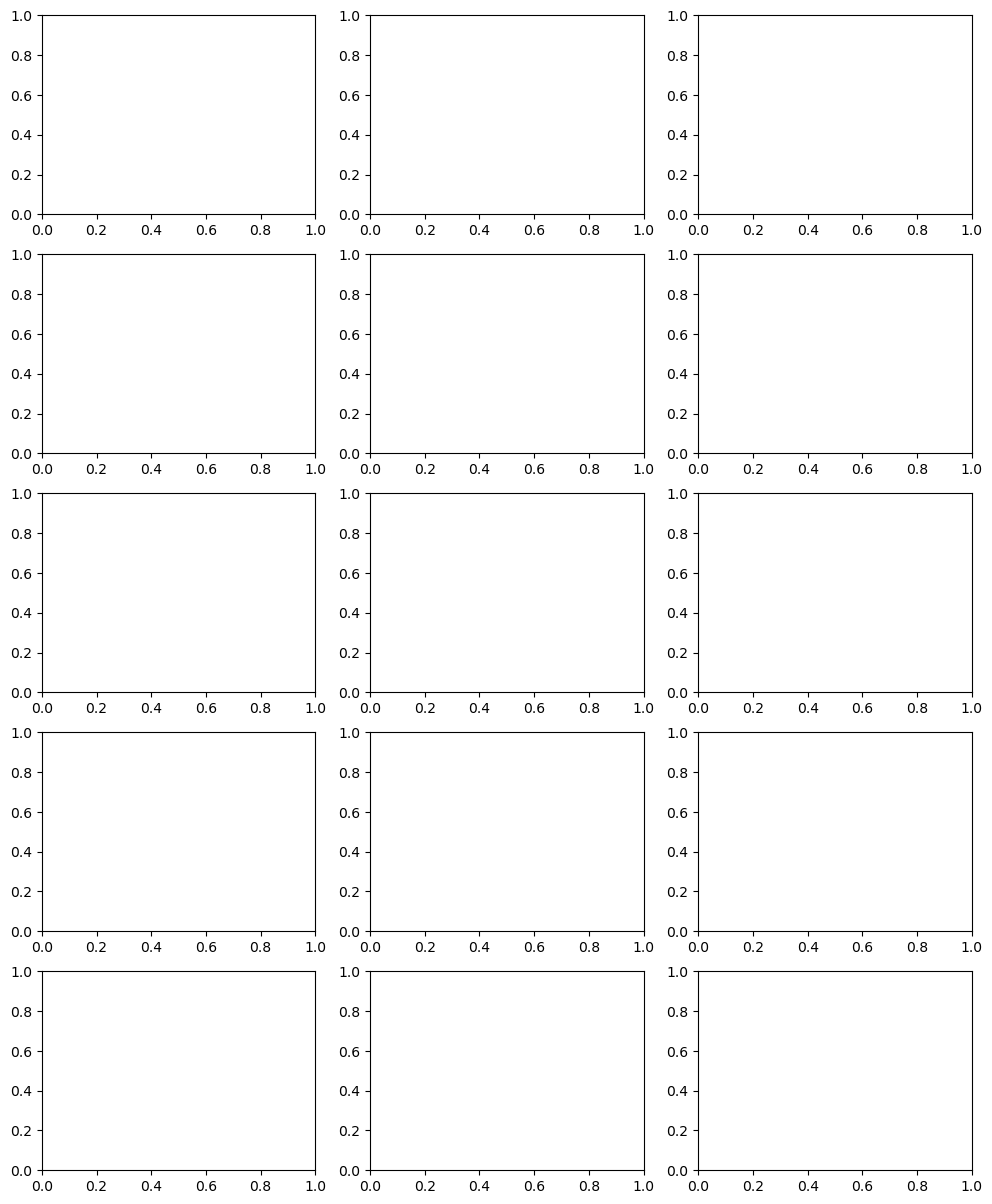

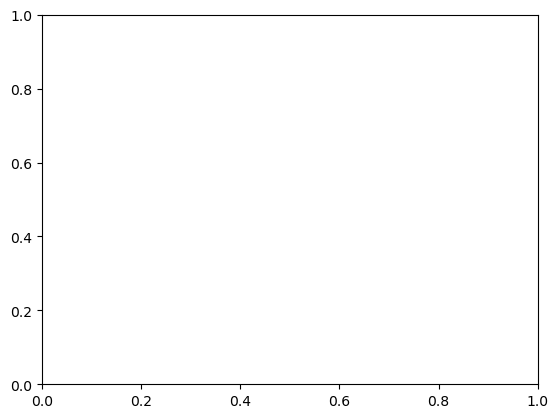

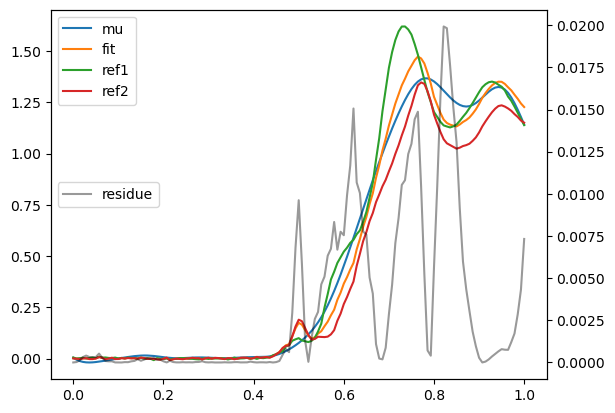

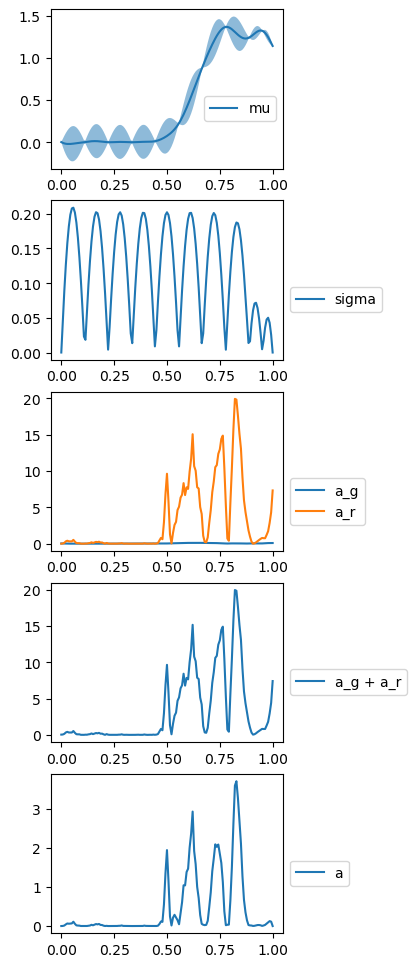

  7%|█████▎                                                                     | 5/70 [00:06<00:54,  1.19it/s]

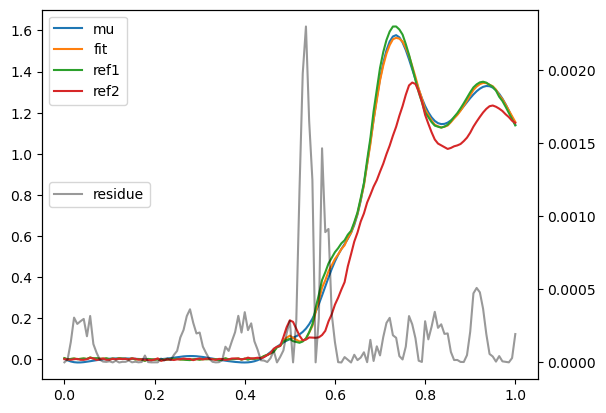

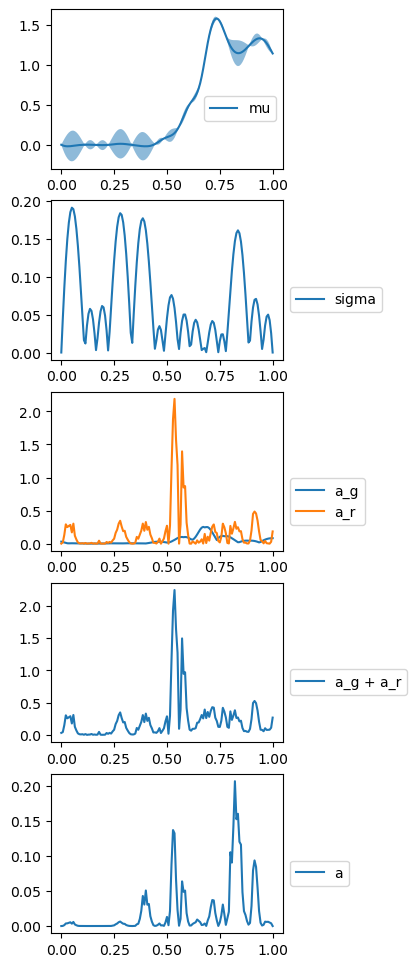

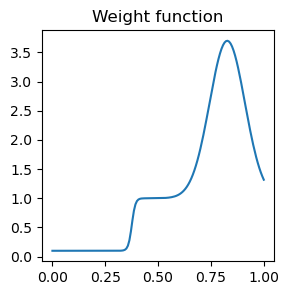

 14%|██████████▌                                                               | 10/70 [00:11<00:44,  1.35it/s]

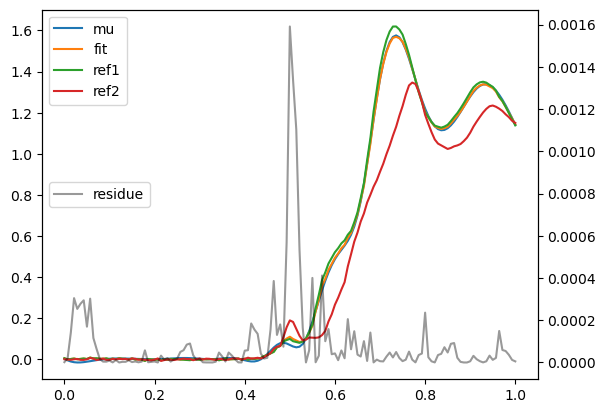

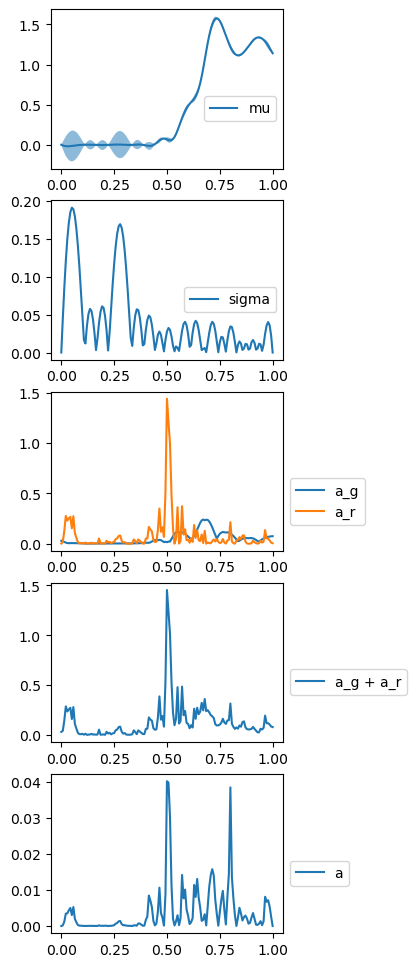

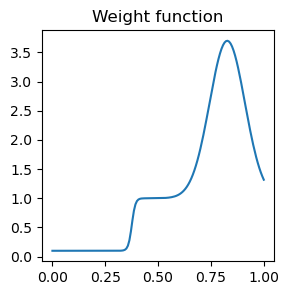

 21%|███████████████▊                                                          | 15/70 [00:15<00:41,  1.33it/s]

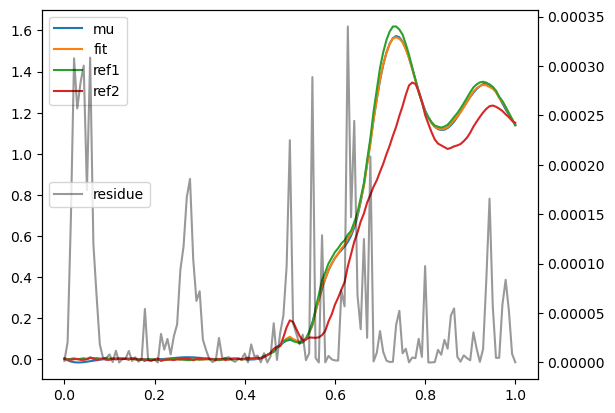

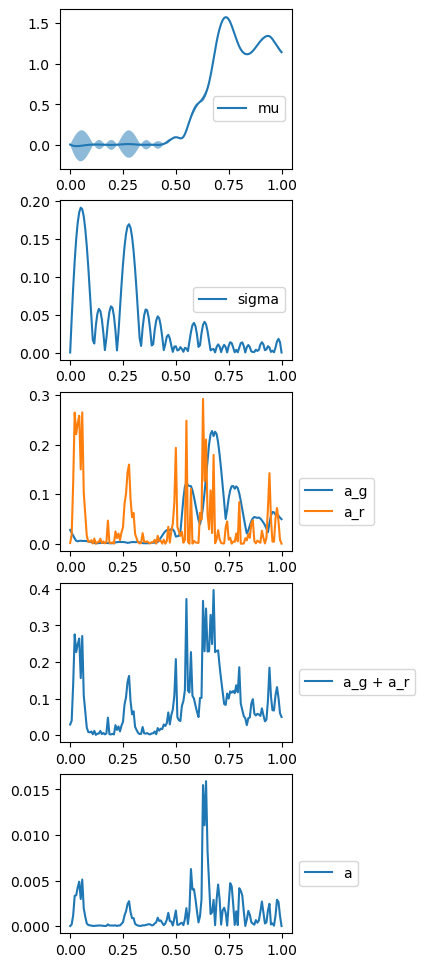

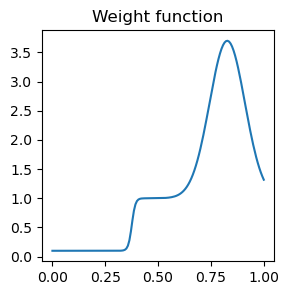

 29%|█████████████████████▏                                                    | 20/70 [00:19<00:36,  1.38it/s]

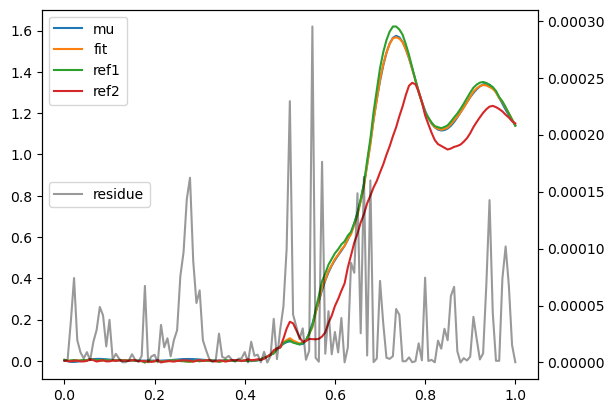

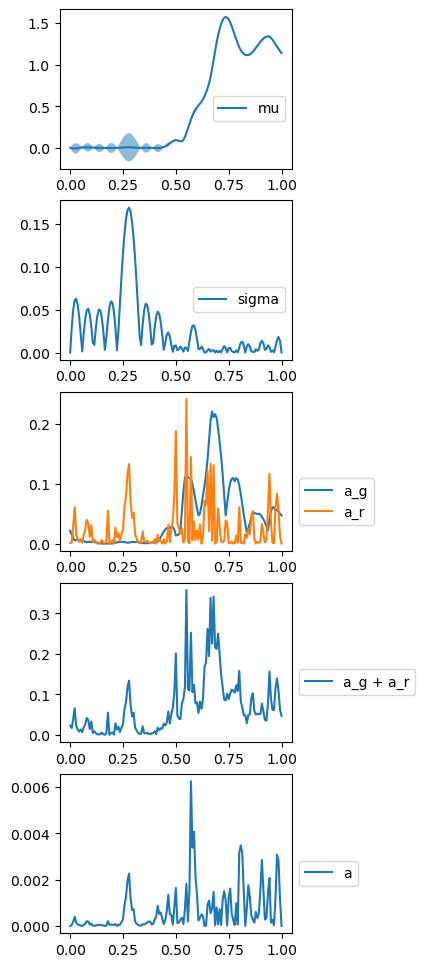

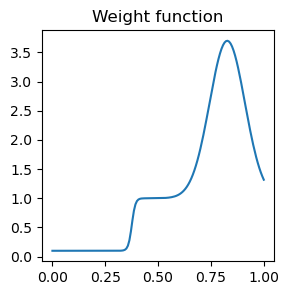

 36%|██████████████████████████▍                                               | 25/70 [00:23<00:29,  1.55it/s]

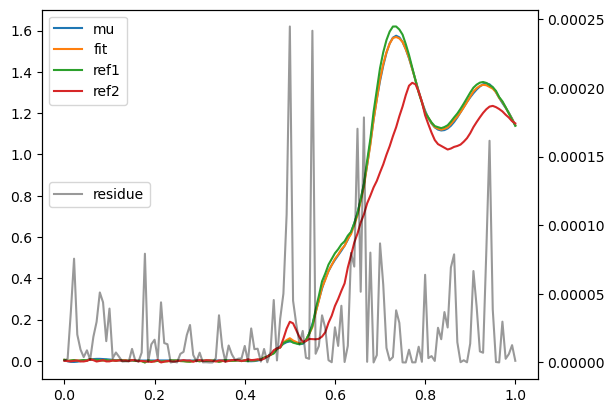

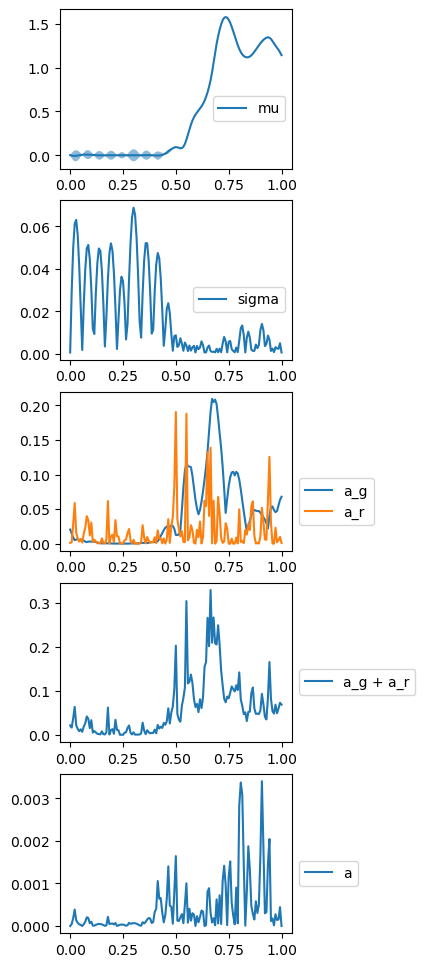

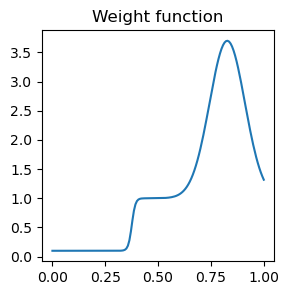

 43%|███████████████████████████████▋                                          | 30/70 [00:27<00:27,  1.48it/s]

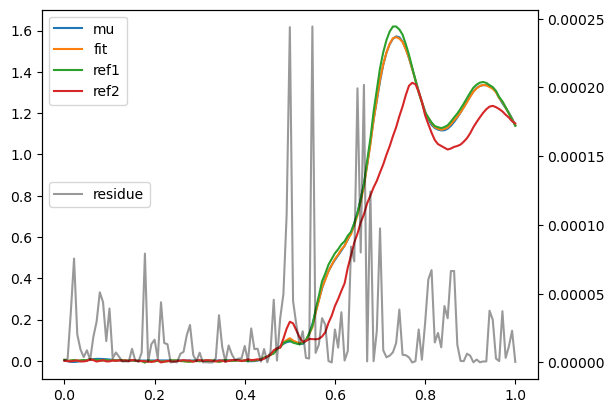

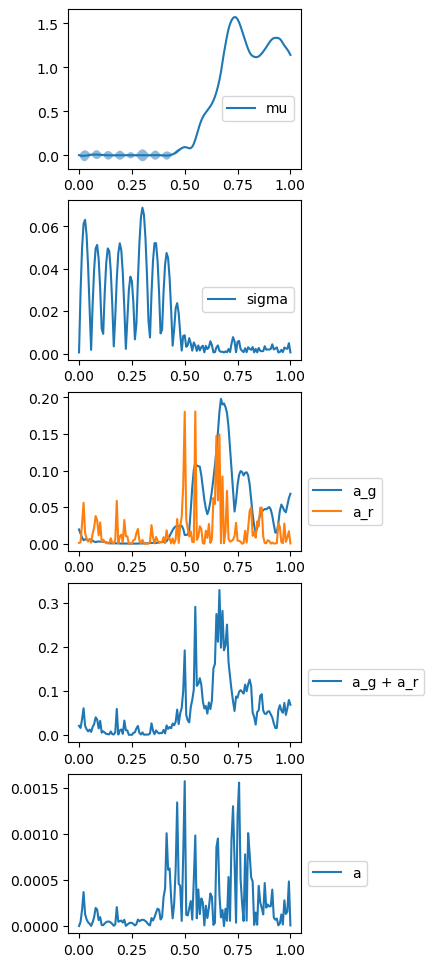

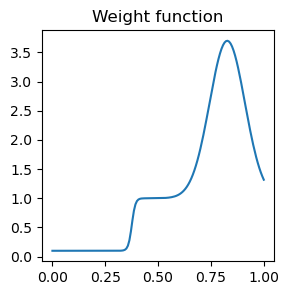

 50%|█████████████████████████████████████                                     | 35/70 [00:31<00:20,  1.69it/s]

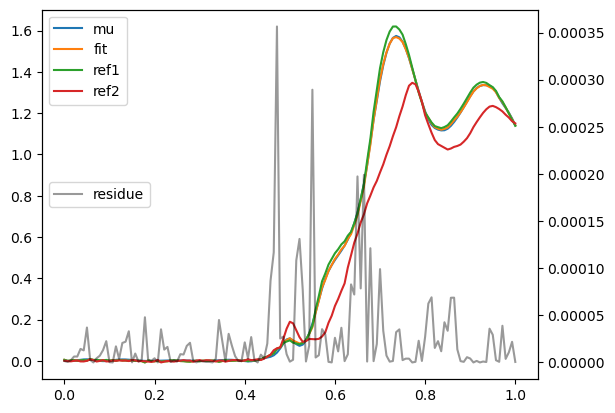

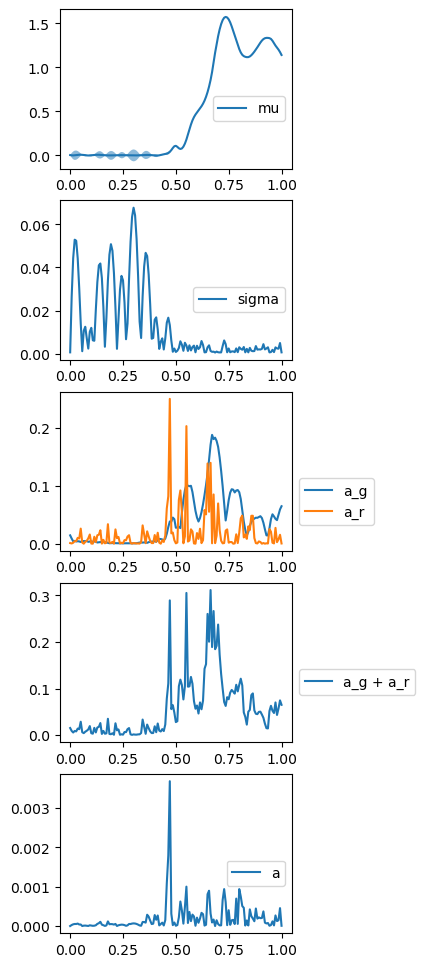

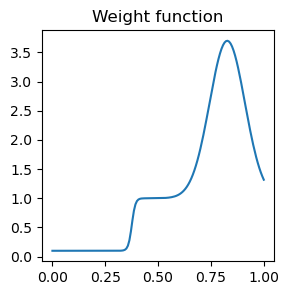

 57%|██████████████████████████████████████████▎                               | 40/70 [00:34<00:17,  1.76it/s]

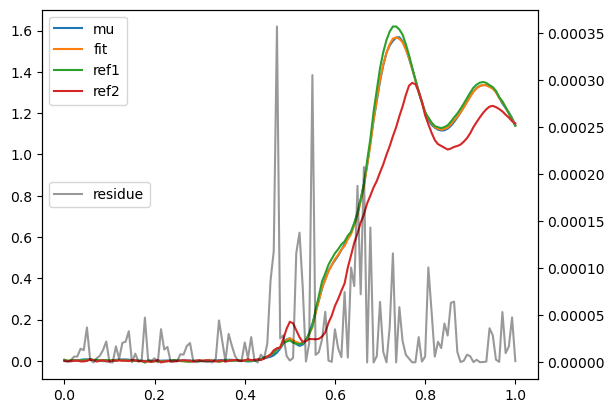

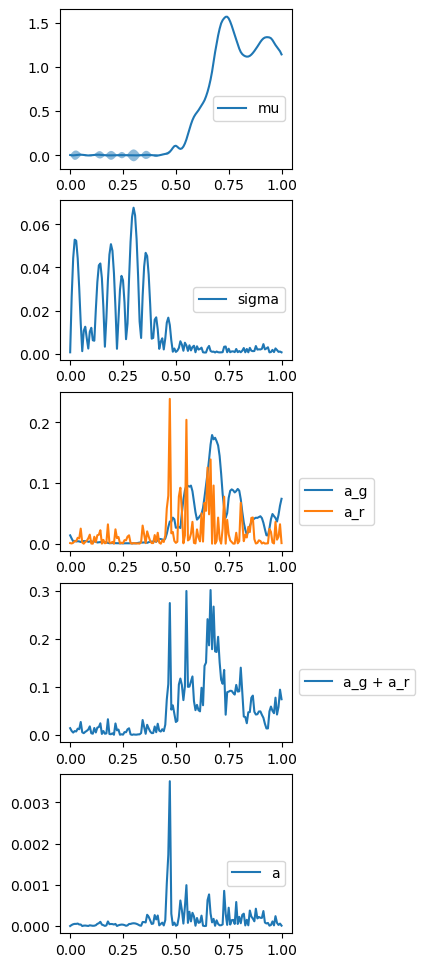

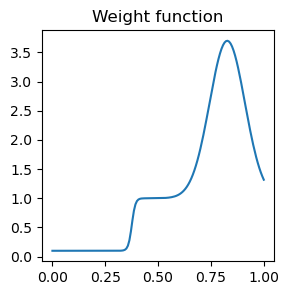

 64%|███████████████████████████████████████████████▌                          | 45/70 [00:38<00:14,  1.69it/s]

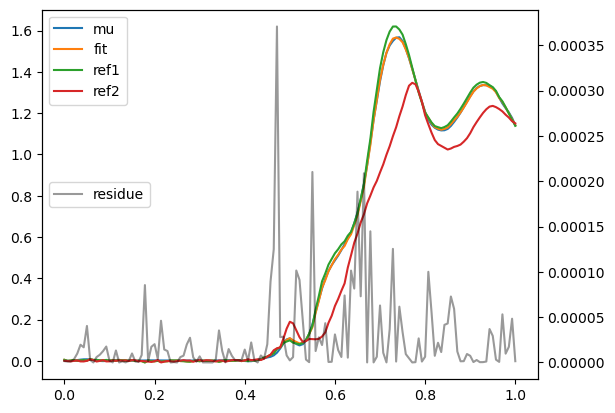

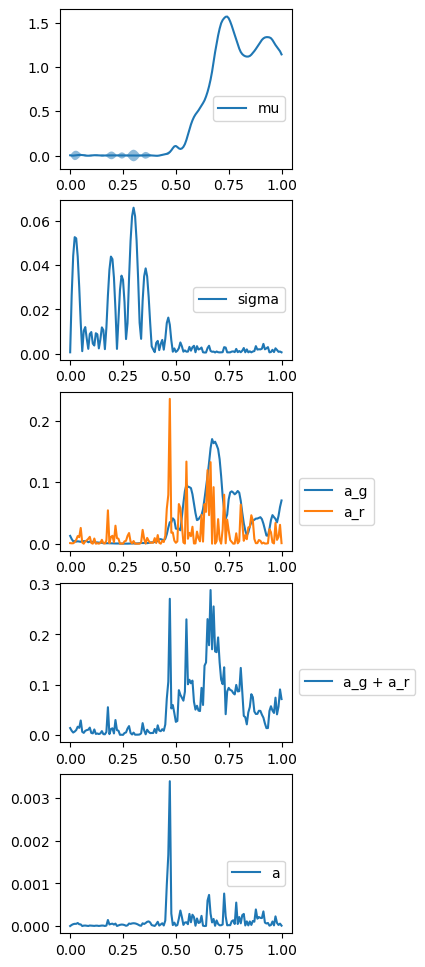

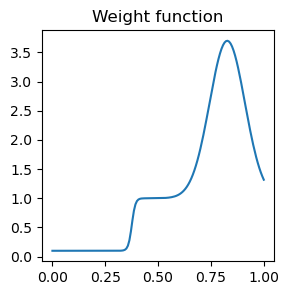

 71%|████████████████████████████████████████████████████▊                     | 50/70 [00:42<00:13,  1.49it/s]

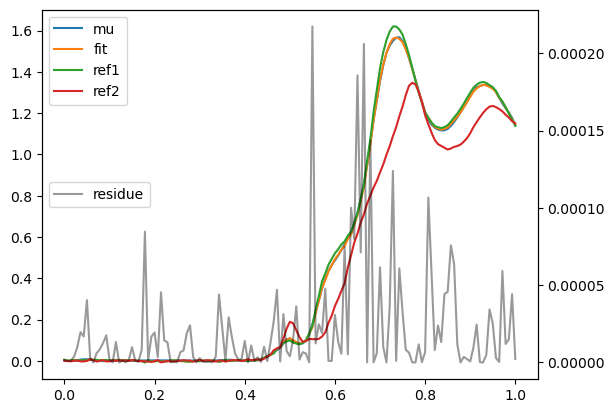

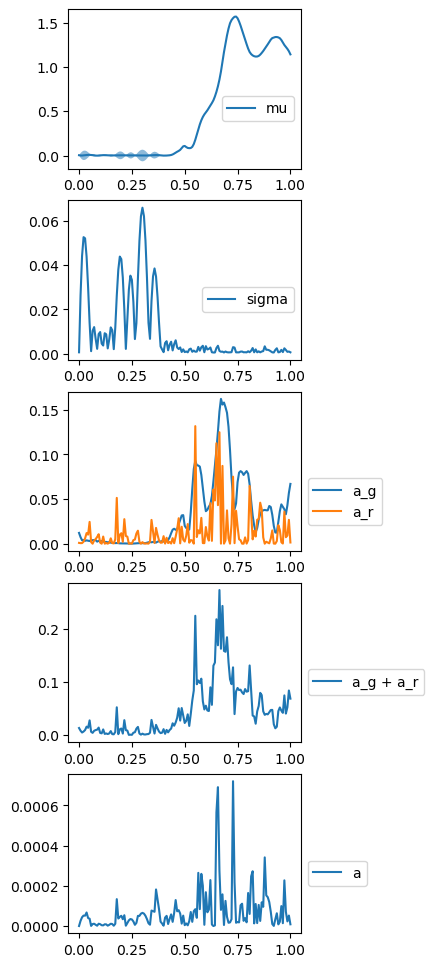

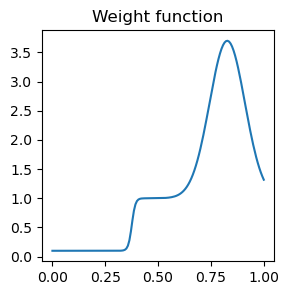

 79%|██████████████████████████████████████████████████████████▏               | 55/70 [00:46<00:10,  1.44it/s]

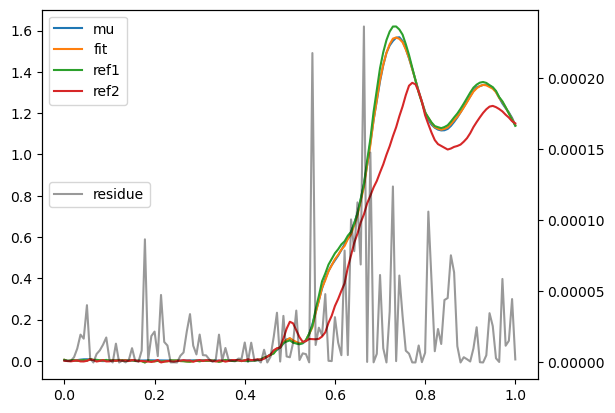

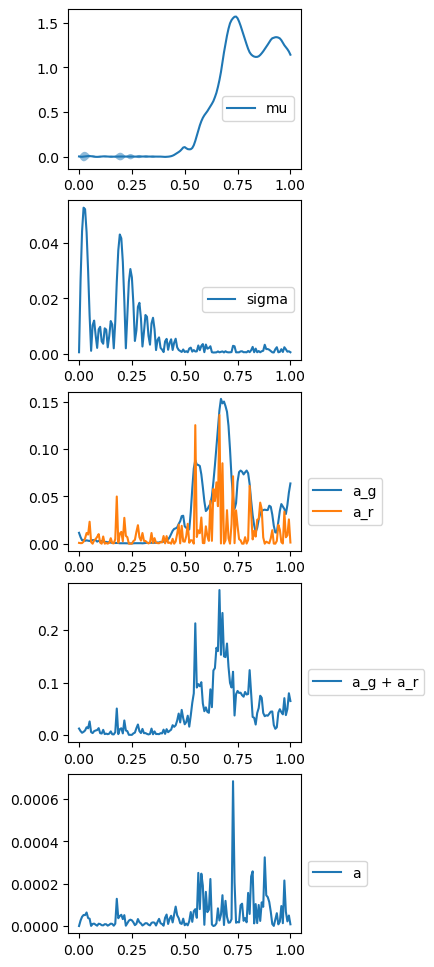

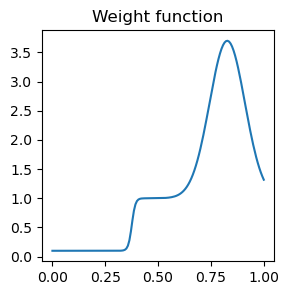

 86%|███████████████████████████████████████████████████████████████▍          | 60/70 [00:50<00:06,  1.46it/s]

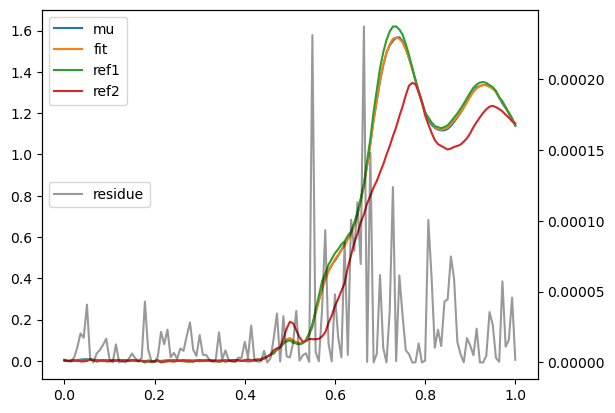

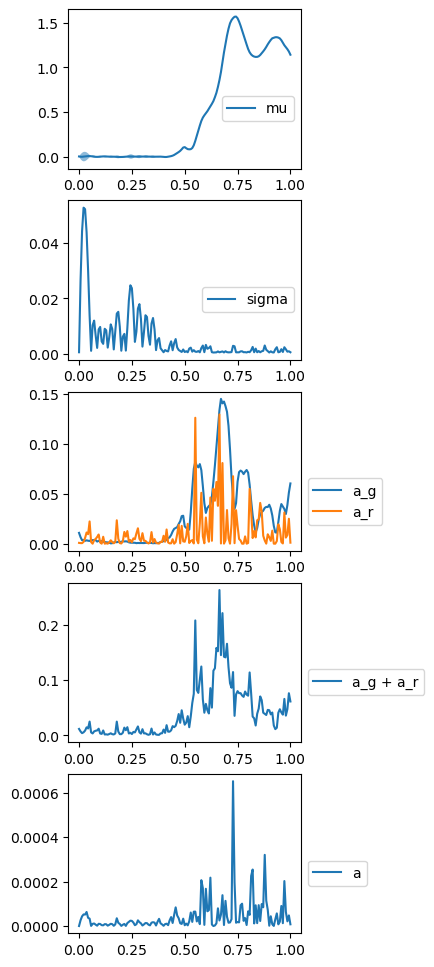

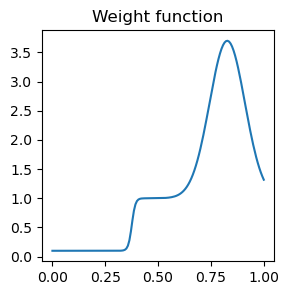

 93%|████████████████████████████████████████████████████████████████████▋     | 65/70 [00:54<00:03,  1.50it/s]

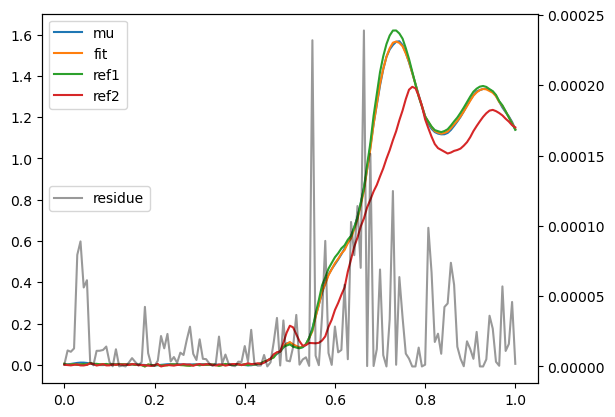

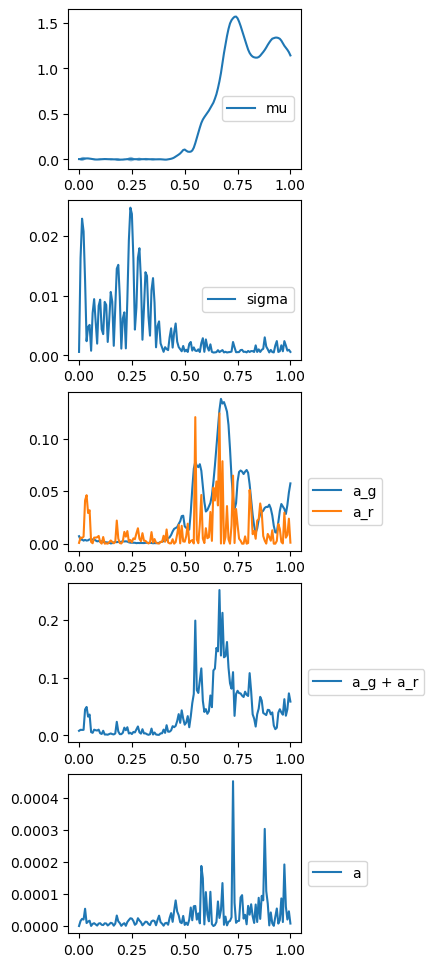

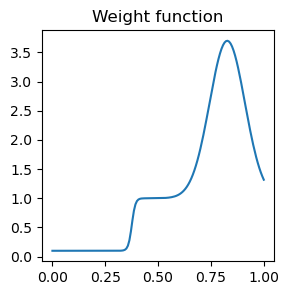

100%|██████████████████████████████████████████████████████████████████████████| 70/70 [00:59<00:00,  1.18it/s]


In [13]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=70)

 # Overall experiment with acquisition functions, acquisition parameters, and kernel parameters

In [ ]:
config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(2.5)}
for acquisition_class in [PosteriorStandardDeviation, GradientAwarePosteriorStandardDeviation]:
    if acquisition_class == GradientAwarePosteriorStandardDeviation:
        config.acquisition_function_params = {'phi': 1e-3}
    else:
        config.acquisition_function_params = {}
    for ls in [3.5, 7.0, 14.0]:
        config.acquisition_function_class = acquisition_class
        config.override_kernel_lengthscale = ls
        run_simulated_experiment(config, x_init, y_init)

config.override_kernel_lengthscale = 7.0
for acquisition_class in [PosteriorStandardDeviation, GradientAwarePosteriorStandardDeviation]:
    if acquisition_class == GradientAwarePosteriorStandardDeviation:
        config.acquisition_function_params = {'phi': 1e-3}
    else:
        config.acquisition_function_params = {}
    for nu in [2.5, 1.5, 0.5]:
        config.acquisition_function_class = acquisition_class
        config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(nu)}
        run_simulated_experiment(config, x_init, y_init)

config.override_kernel_lengthscale = 7.0
config.acquisition_function_class = GradientAwarePosteriorStandardDeviation
config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(2.5)}
for phi in [1e-3, 1e-2]:
    config.acquisition_function_params = {'phi': phi}
    run_simulated_experiment(config, x_init, y_init)

## Combine convergence plots

In [ ]:
def combine_convergence_plots(data_dir='outputs/gradient_acquisition'):
    flist = sorted(glob.glob(os.path.join(data_dir, '*_conv.txt')))
    fig, ax = plt.subplots(1, 1)
    for fname in flist:
        name = os.path.basename(fname)
        name = name[:name.find('_conv.txt')]
        data = np.loadtxt(fname)
        ax.plot(data[0], data[1], label=name)
    ax.set_xlabel('Points measured')
    ax.set_ylabel('RMS')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    plt.tight_layout()
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False, ncol=1)
    plt.savefig(os.path.join(data_dir, 'combined_conv_plots.pdf'), bbox_inches='tight')

In [ ]:
combine_convergence_plots()

# YBCO data

In [14]:
data_path = 'data/raw/YBCO/YBCO3data.csv'
data_all_spectra = pd.read_csv(data_path, header=0)
# Only keep 8920 - 9080 eV
data_all_spectra = data_all_spectra.iloc[14:232]
data_all_spectra

energy  YBCO_epara.0001  YBCO_eparc.0001  YBCO_epararb.0001
14   8921.3895        -0.000731        -0.000159          -0.001650
15   8931.5417        -0.000229        -0.000714          -0.001560
16   8941.6316         0.000681         0.000286          -0.001462
17   8951.6931         0.001454         0.001234          -0.000006
18   8961.8816         0.003856         0.003720           0.002051
..         ...              ...              ...                ...
227  9073.6476         1.029671         1.031639           1.028860
228  9075.4923         1.023071         1.035609           1.026010
229  9077.4265         1.012816         1.033167           1.019481
230  9079.2550         1.002068         1.025874           1.009070
231  9081.2975         0.987573         1.013350           0.995380

[218 rows x 4 columns]

In [15]:
def linear_fit(basis_list, data):
    a = np.stack([to_numpy(ref_spectra_0), to_numpy(ref_spectra_1)]).T
    b = data.reshape(-1, 1)
    x = np.linalg.pinv(a) @ b
    y_fit = (a @ x).reshape(-1)
    return y_fit

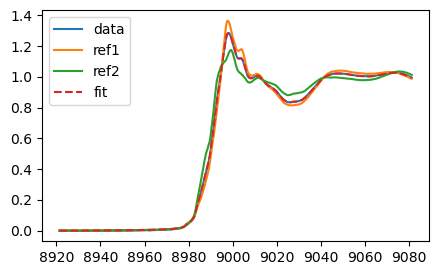

In [16]:
data = data_all_spectra['YBCO_epararb.0001'].to_numpy()
ref_spectra_0 = torch.tensor(data_all_spectra['YBCO_epara.0001'].to_numpy())
ref_spectra_1 = torch.tensor(data_all_spectra['YBCO_eparc.0001'].to_numpy())
energies = data_all_spectra['energy'].to_numpy()
energies = torch.tensor(energies)
y_fit = linear_fit([to_numpy(ref_spectra_0), to_numpy(ref_spectra_1)], data)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), data, label='data')
ax.plot(to_numpy(energies), to_numpy(ref_spectra_0), label='ref1')
ax.plot(to_numpy(energies), to_numpy(ref_spectra_1), label='ref2')
ax.plot(to_numpy(energies), y_fit, label='fit', linestyle='--')
plt.legend()
plt.show()

In [17]:
instrument = SimulatedMeasurement(data=(energies[None, :], data))

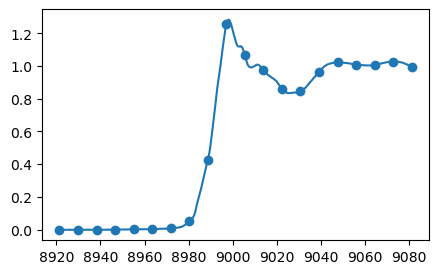

In [18]:
n_init = 20
x_init = torch.linspace(energies[0], energies[-1], n_init).double().reshape(-1, 1)
y_init = instrument.measure(x_init).reshape(-1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), to_numpy(data))
ax.scatter(to_numpy(x_init), to_numpy(y_init))
plt.show()

In [19]:
ref_spectra_y = torch.stack([ref_spectra_0, ref_spectra_1], dim=0)
ref_spectra_x = energies

config = XANESExperimentGuideConfig(
        dim_measurement_space=1,
        num_candidates=1,
        model_class=botorch.models.SingleTaskGP,
        model_params={'covar_module': gpytorch.kernels.MaternKernel(2.5)},
        noise_variance=1e-6,
        override_kernel_lengthscale=7,
        lower_bounds=torch.tensor([energies[0]]),
        upper_bounds=torch.tensor([energies[-1]]),
    
        # optimizer_class=ContinuousOptimizer,
        # optimizer_params={'num_restarts': 2,}
        #                   #'options': {'maxiter': 2}}
    
        # optimizer_class=DiscreteOptimizer,
        # optimizer_params={'optim_func': botorch.optim.optimize.optimize_acqf_discrete, 
        #                   'optim_func_params': {
        #                       'choices': torch.linspace(0, 1, len(energies))[:, None]
        #                   }
        #                  }
    
        optimizer_class=TorchOptimizer,
        optimizer_params={'torch_optimizer': torch.optim.Adam, 'torch_optimizer_options': {'maxiter': 20}},
        n_updates_create_acqf_weight_func=5,
        acqf_weight_func_floor_value=0.1,
        acqf_weight_func_post_edge_gain=3.0
)

config.acquisition_function_class = ComprehensiveAugmentedAcquisitionFunction
config.acquisition_function_params = {'gradient_order': 2,
                                      'differentiation_method': 'numerical',
                                      'reference_spectra_x': ref_spectra_x, 
                                      'reference_spectra_y': ref_spectra_y, 
                                      'phi_r': 1e3,
                                      'phi_g': 1e-2, #2e-2,
                                      'phi_g2': 1e-4, #3e-4
                                      'addon_term_lower_bound': 1e-2,
                                      'debug': True
                                     }

[2024-04-17 16:12:27,127] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-17 16:12:27,226] Kernel lengthscale after optimization (normalized & standardized): [[0.10491803]]
[2024-04-17 16:12:27,229] Kernel lengthscale overriden to: 7 (0.04377511511731585 after normalization)
  0%|                                                                                   | 0/50 [00:00<?, ?it/s]

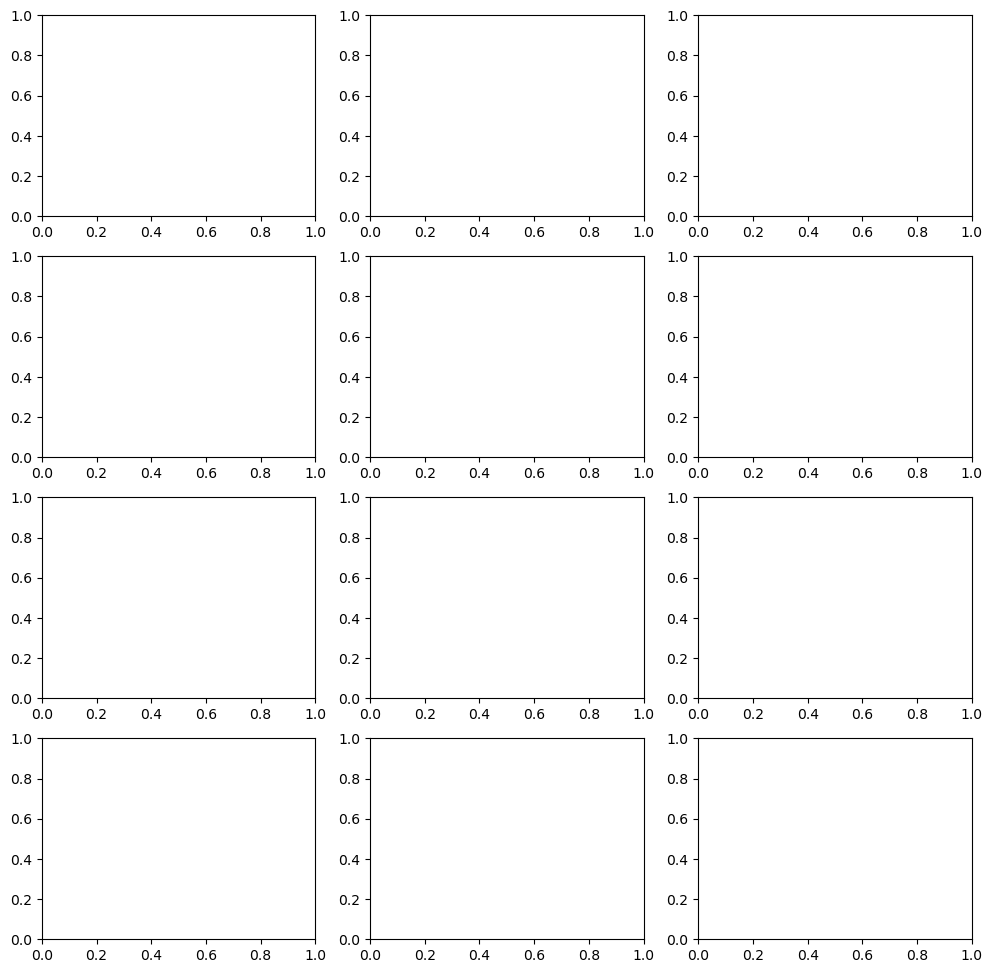

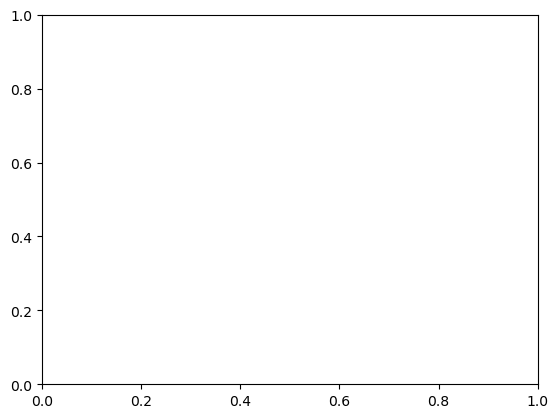

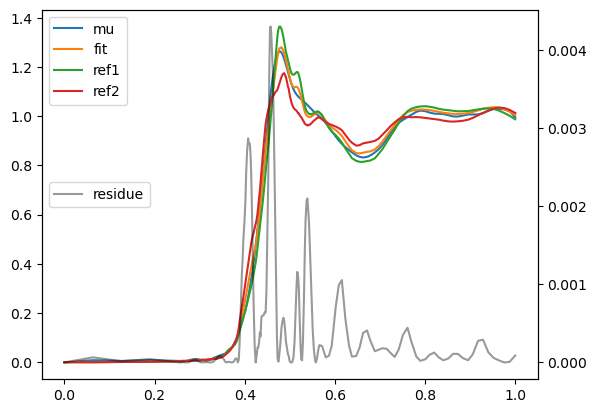

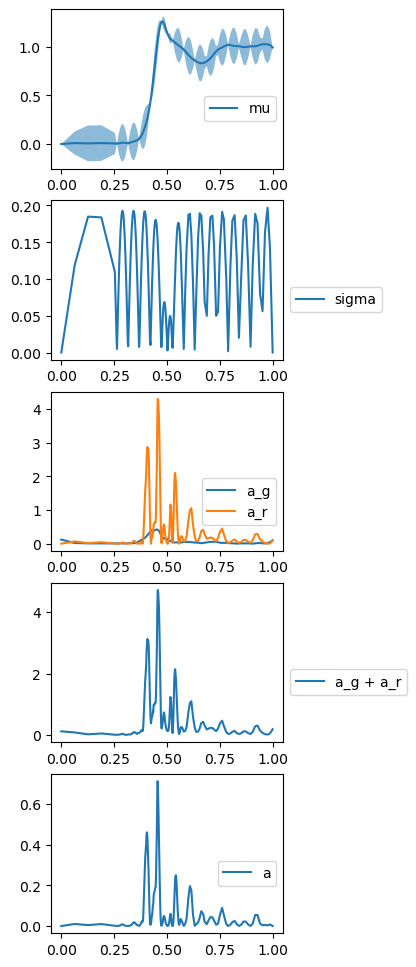

 10%|███████▌                                                                   | 5/50 [00:04<00:27,  1.65it/s]

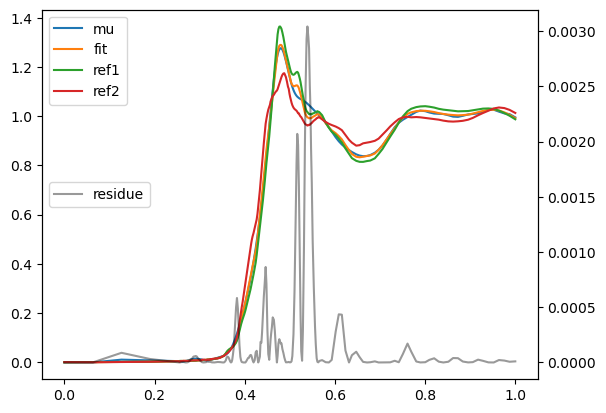

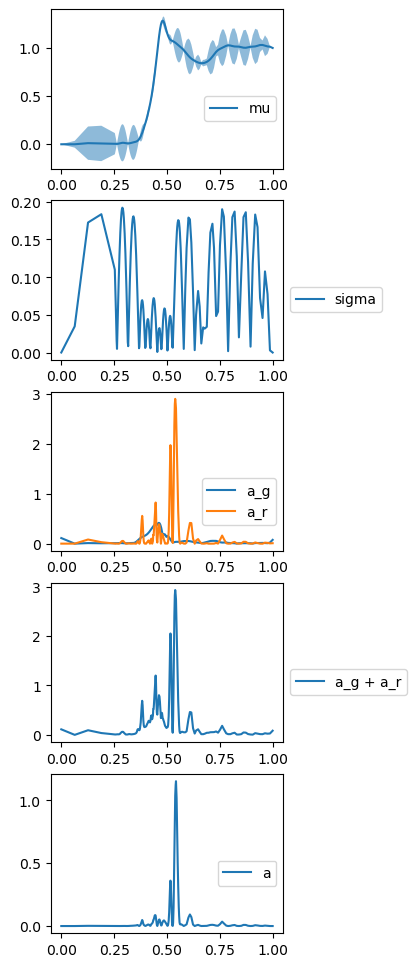

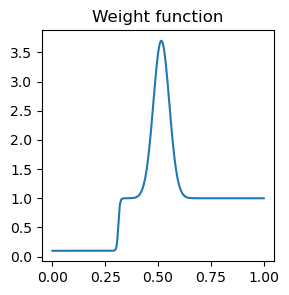

 20%|██████████████▊                                                           | 10/50 [00:08<00:29,  1.35it/s]

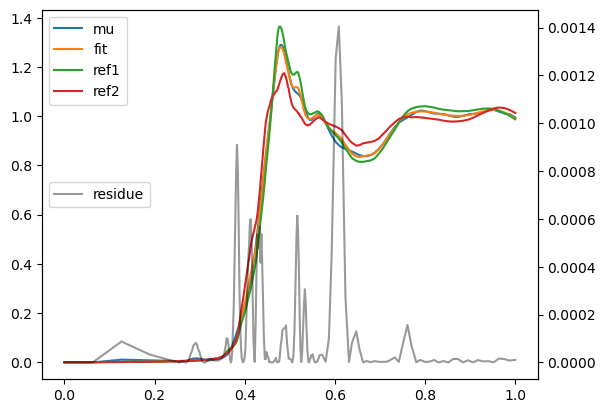

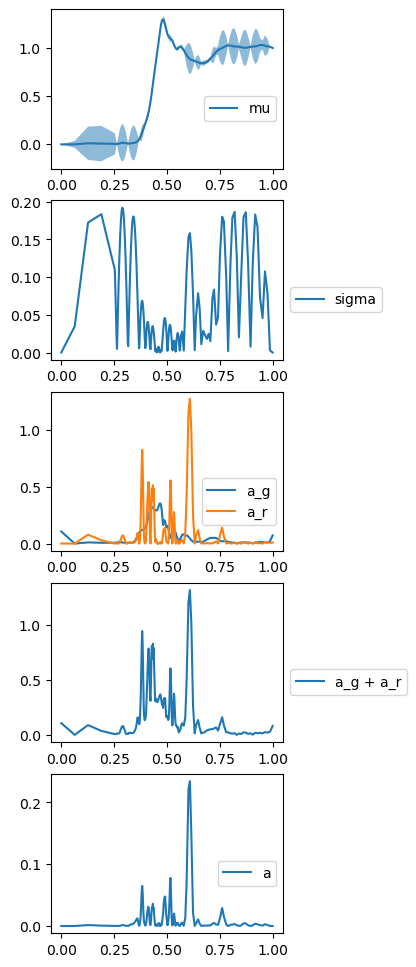

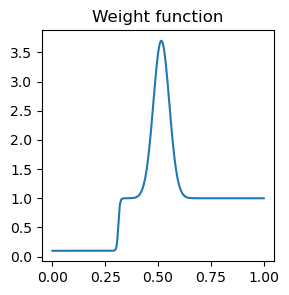

 30%|██████████████████████▏                                                   | 15/50 [00:12<00:22,  1.58it/s]

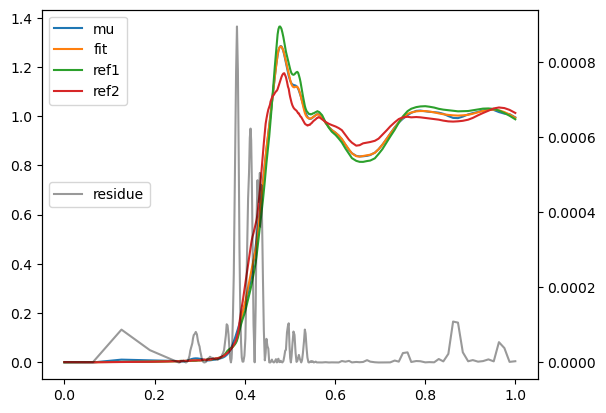

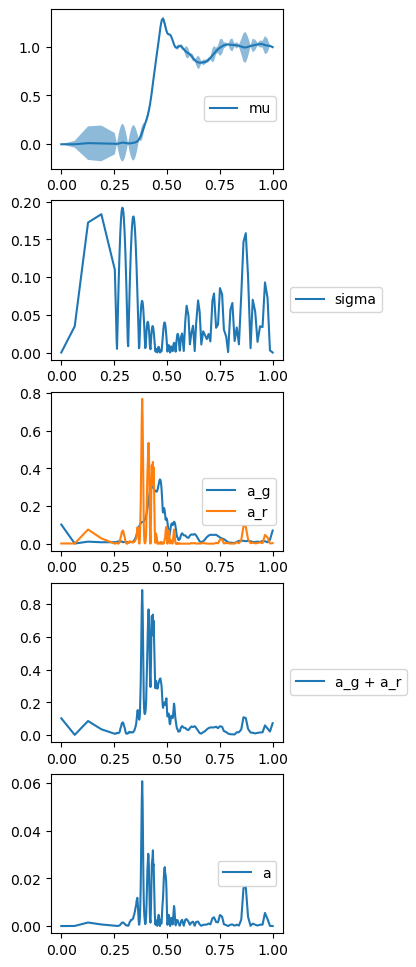

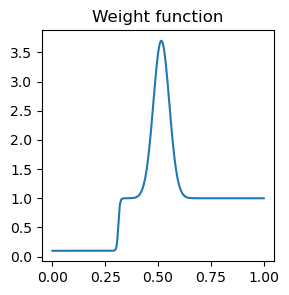

 40%|█████████████████████████████▌                                            | 20/50 [00:15<00:20,  1.47it/s]

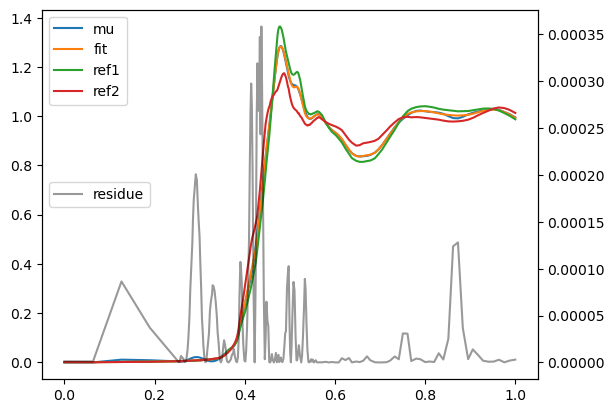

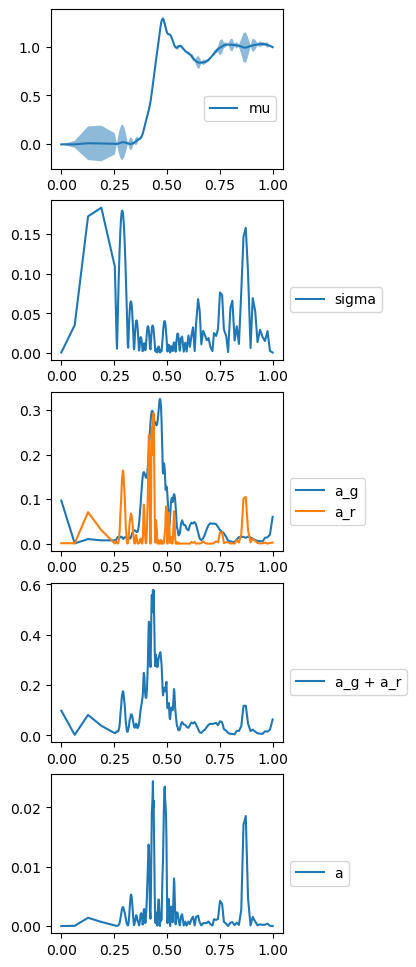

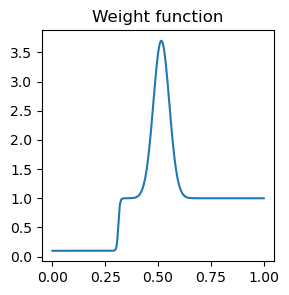

 50%|█████████████████████████████████████                                     | 25/50 [00:19<00:14,  1.67it/s]

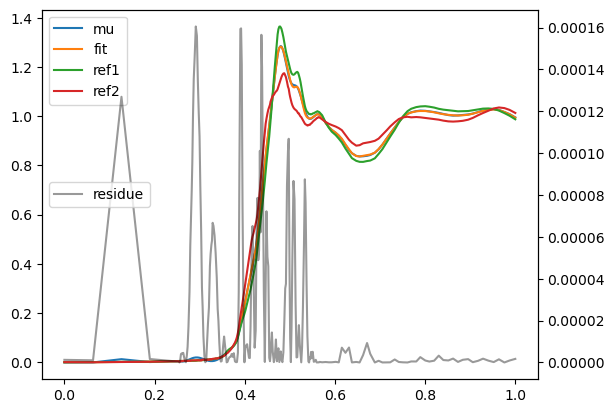

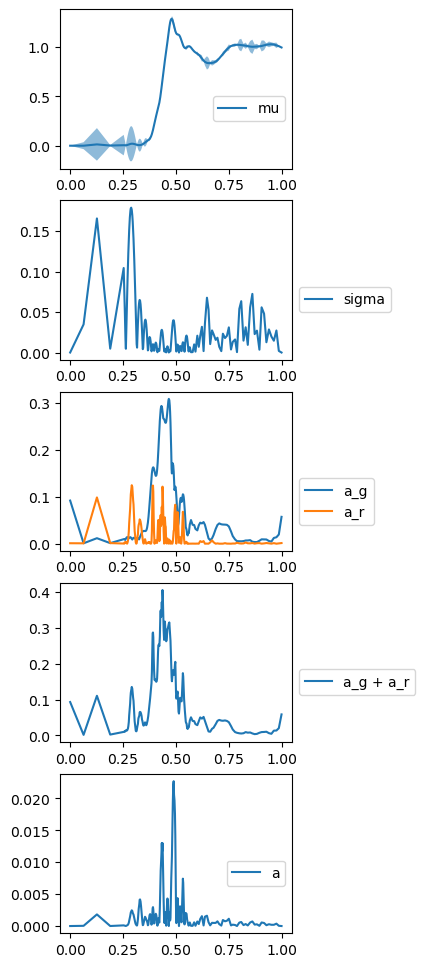

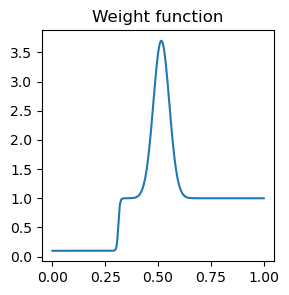

 60%|████████████████████████████████████████████▍                             | 30/50 [00:23<00:12,  1.55it/s]

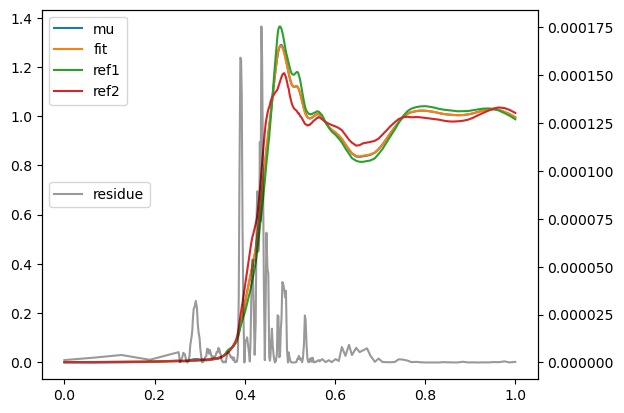

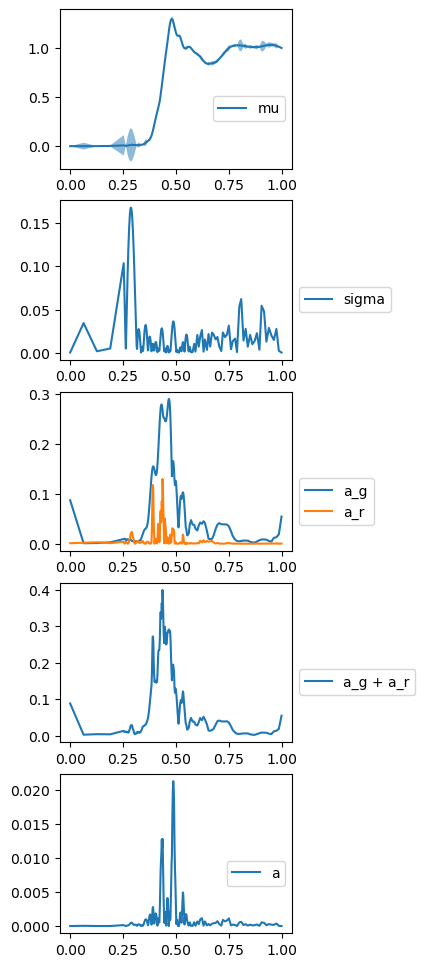

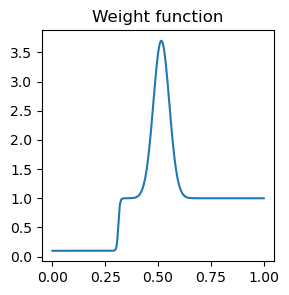

 70%|███████████████████████████████████████████████████▊                      | 35/50 [00:27<00:08,  1.69it/s]

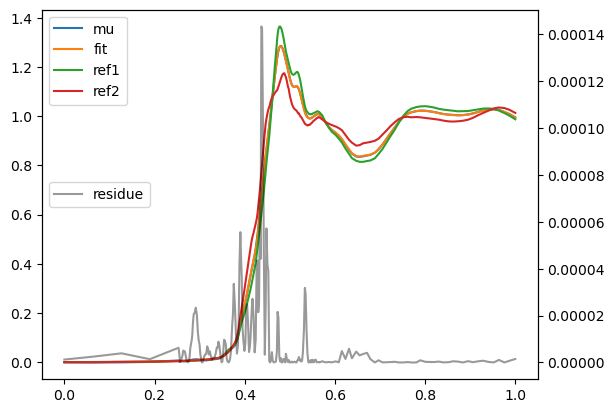

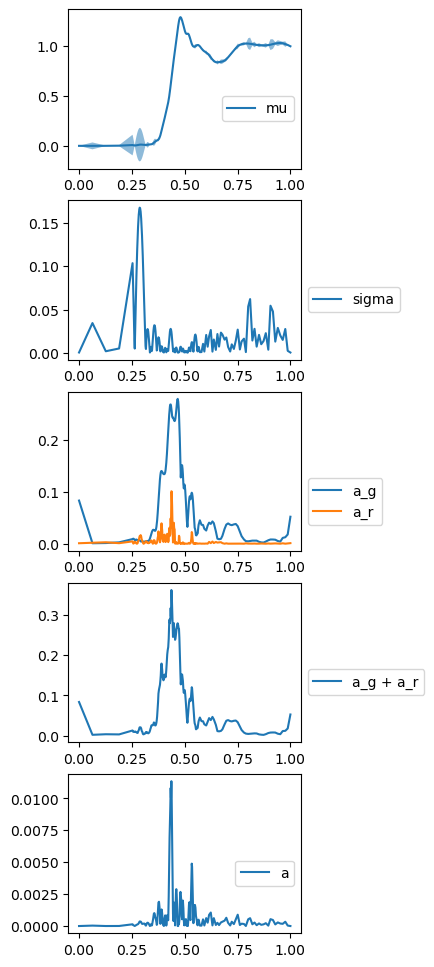

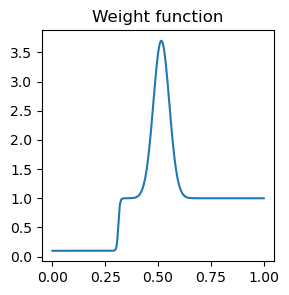

 80%|███████████████████████████████████████████████████████████▏              | 40/50 [00:31<00:06,  1.48it/s]

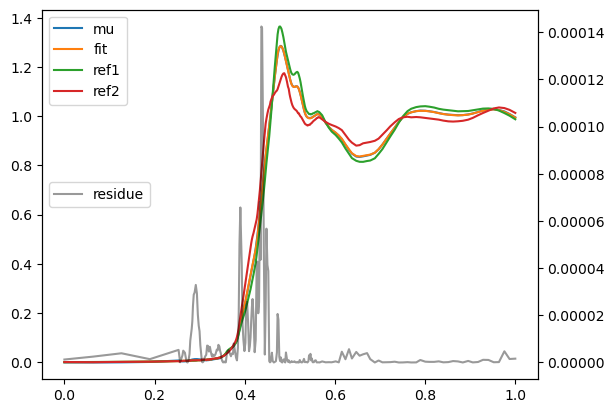

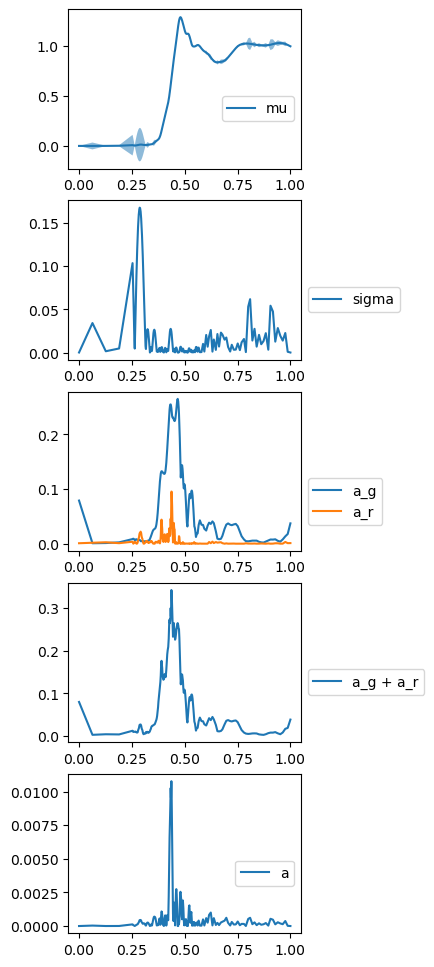

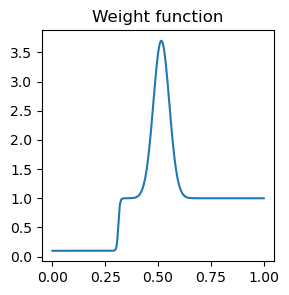

 90%|██████████████████████████████████████████████████████████████████▌       | 45/50 [00:35<00:03,  1.36it/s]

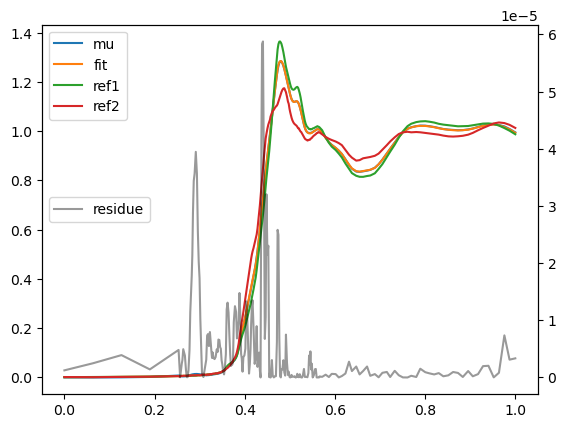

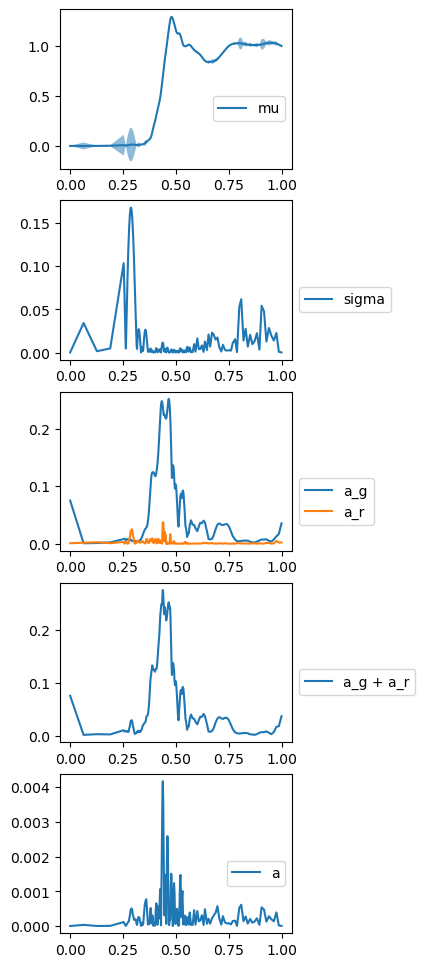

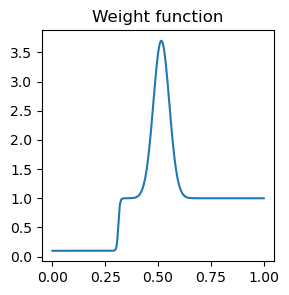

100%|██████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.28it/s]


In [20]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=50)